In [ ]:
import sys 
sys.path.add('../')

In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from torchvision import transforms
import torchvision
import torch
from NestingLayer import *
from tqdm.notebook import tqdm
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline
import os
%config InlineBackend.figure_format='retina'
from skimage.util import montage
import skimage

In [2]:
def per_class_accuracy(prediction, ground_truth, NC=1000):
    acc = torch.zeros((prediction.shape[0], NC)).cuda()
    for j in range(prediction.shape[0]):
        for i in range(NC):
            idx = ground_truth==i    
            acc[j, i] = ((prediction[j][idx]==i).sum())/idx.sum()
    return acc

In [3]:
import pickle as pkl
def read_pkl(name):
    with open(name, 'rb') as f:
        return pkl.load(f)

In [4]:
id_name_mapping = read_pkl("id_name_mapping.pkl")

In [5]:
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
resize_size = 256
center_crop_size = 224
t = transforms.Compose([
				transforms.Resize(resize_size),
				transforms.CenterCrop(center_crop_size),
				transforms.ToTensor(),
				normalize])


In [7]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)


## Multi Head Model

In [10]:
preds_all= torch.load("predictions_sh=False_mh=True_ff=False_feat_dim=2048_dataset=V1.pth")
gt = torch.load("gt_dataset=V1.pth")

softmax_= torch.load('softmax_sh=False_mh=True_ff=False_feat_dim=2048_dataset=V1.pth')
softmax_top5 = torch.topk(softmax_,  dim=-1, k=5)[1]

In [11]:
# Note that the snippet below uses sh for MRL-E and mh for MRL
def get_sh_ff_eqiv(model, in_features, out_features=1000,efficient=True, nesting_list=None):
	if efficient:	
		weight_ = model.fc.nesting_classifier_0.weight.data[:,:in_features]
		bias_= model.fc.nesting_classifier_0.bias.data
	else:
		idx= nesting_list.index(in_features)
		fc_mh = getattr(model.fc, f"nesting_classifier_{idx}")
		weight_ = fc_mh.weight.data
		bias_= fc_mh.bias.data

	fc = FixedFeatureLayer(in_features, out_features)
	fc.weight.data = weight_
	fc.bias.data = bias_
	model.fc = fc

	return model

In [30]:
# some bunch of configs that will help us to identify the model
nesting_start = 3
feat_dim=128
'''
Flag Config:
MRL: mh=1; sh=0
MRL-E: mh=0; sh=1
FF: mh=0;sh=0
'''
sh=0
mh=1 

old_ckpt=False # NOTE THAT THIS IS ONLY TO BE USED IN CASE YOU WANT TO DO GRADCAM ON OUR UPLOADED CKPTS. 
path = f"./sh={sh}_mh={mh}_nesting_start=3_fixed_feature=2048/final_weights.pt" # this should be changed to the rspective new paths...

#### Note that the code above requires val set images to be of the form X_{class_id}.pth (50, 3, 224, 224) for each class.  Therefore, before running, please do the following pre-processing. 

In [31]:
class_specific_idx= 62 # Can be any class of interest.
print("Loading Model...")
nesting_list=None
idx = gt==class_specific_idx

X_ = torch.load(f"val_tensors/X_{class_specific_idx}.pth").cuda(non_blocking=True) # please store the val images as tensor beforehand.
preds_ = preds_all[:, idx]
sofmtax_top5_ = softmax_top5[:, idx, :]
all_gradcam={}
all_gradcam["sh"]={}
nesting_list=[2**i for i in range(nesting_start, 12)]

print("Is MRL: ", mh, "Is Efficient: ", sh)

for feat_dim in nesting_list:
    model = resnet50(False)
    if not (sh or mh):
        model.fc=FixedFeatureLayer(feat_dim, 1000)
    else:
        if old_ckpt:
            model = load_from_old_ckpt(model, sh, nesting_list)
        else:
            model.fc = MRL_Linear_Layer(nesting_list, efficient=sh)	

    apply_blurpool(model)		
    model.load_state_dict(get_ckpt(path))

    print("Feature Dimension", feat_dim)
    model=get_sh_ff_eqiv(model, feat_dim, sh=sh, nesting_list=nesting_list).cuda()
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    grayscale_cam = cam(input_tensor=(X_).cuda(), targets=[ClassifierOutputTarget(class_specific_idx) for i in range(len(X_))])
    all_gradcam["sh"][feat_dim] = grayscale_cam
    
    model=None
    torch.cuda.empty_cache() 

print("================", "\n")
    
# Printing the accuracy for that particular class. 
for i, ff in enumerate(nesting_list):
    print(f"Feature Dimension: {ff}")
    print("Accuracy \t ", ((preds_[i, :] == class_specific_idx).sum()/50).item())

Loading Model...
0
Feature Dimension 8
Feature Dimension 16
Feature Dimension 32
Feature Dimension 64
Feature Dimension 128
Feature Dimension 256
Feature Dimension 512
Feature Dimension 1024
Feature Dimension 2048

Feature Dimension: 8
Accuracy 	  0.2199999988079071
Feature Dimension: 16
Accuracy 	  0.5799999833106995
Feature Dimension: 32
Accuracy 	  0.5400000214576721
Feature Dimension: 64
Accuracy 	  0.5400000214576721
Feature Dimension: 128
Accuracy 	  0.5199999809265137
Feature Dimension: 256
Accuracy 	  0.5199999809265137
Feature Dimension: 512
Accuracy 	  0.5199999809265137
Feature Dimension: 1024
Accuracy 	  0.5199999809265137
Feature Dimension: 2048
Accuracy 	  0.5199999809265137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


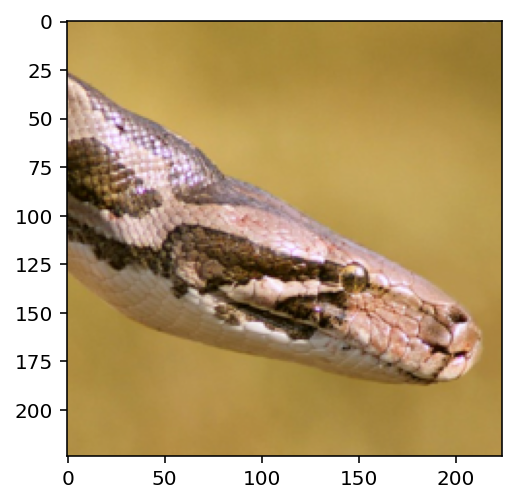

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature Dimensionality 8
Ground Truth: 	 rock python, rock snake, Python sebae
Predicted Label: 	 boa constrictor, Constrictor constrictor
Top 5 Predictions Labels:  	 ['boa constrictor, Constrictor constrictor', 'rock python, rock snake, Python sebae', 'night snake, Hypsiglena torquata', 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus', 'plate rack']
Ground Truth Class ID 62 Predicted Class ID 61


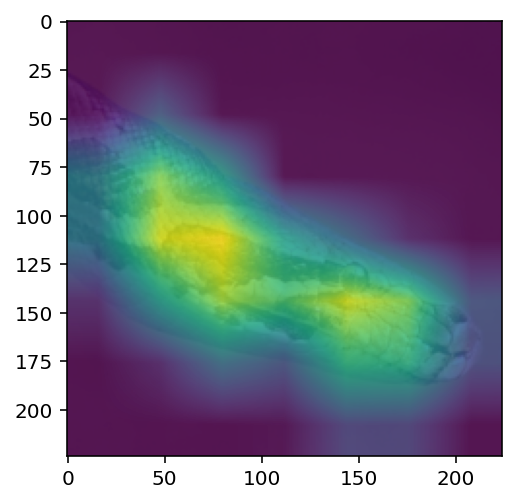

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature Dimensionality 16
Ground Truth: 	 rock python, rock snake, Python sebae
Predicted Label: 	 rock python, rock snake, Python sebae
Top 5 Predictions Labels:  	 ['rock python, rock snake, Python sebae', 'boa constrictor, Constrictor constrictor', 'night snake, Hypsiglena torquata', 'handkerchief, hankie, hanky, hankey', 'cliff dwelling']
Ground Truth Class ID 62 Predicted Class ID 62


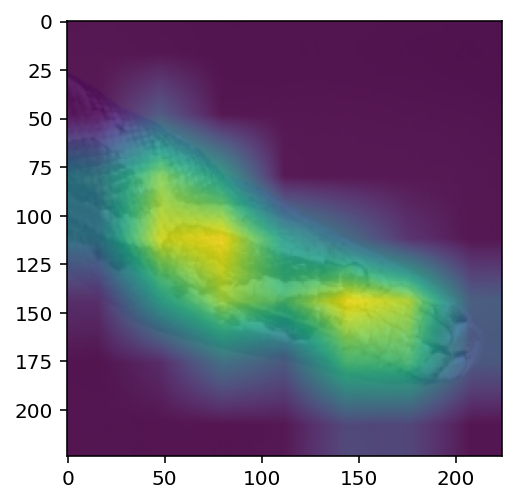

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature Dimensionality 32
Ground Truth: 	 rock python, rock snake, Python sebae
Predicted Label: 	 rock python, rock snake, Python sebae
Top 5 Predictions Labels:  	 ['rock python, rock snake, Python sebae', 'boa constrictor, Constrictor constrictor', 'night snake, Hypsiglena torquata', 'king snake, kingsnake', 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus']
Ground Truth Class ID 62 Predicted Class ID 62


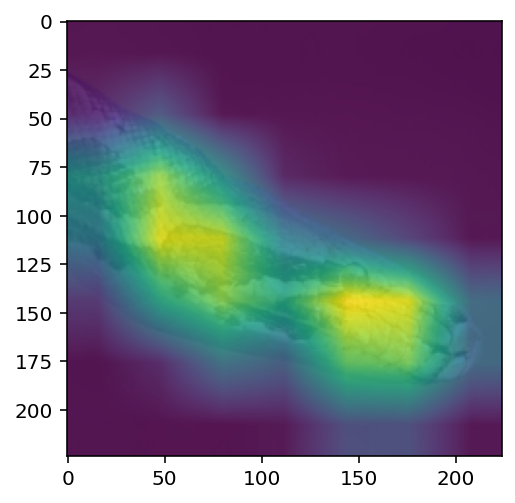

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature Dimensionality 64
Ground Truth: 	 rock python, rock snake, Python sebae
Predicted Label: 	 rock python, rock snake, Python sebae
Top 5 Predictions Labels:  	 ['rock python, rock snake, Python sebae', 'boa constrictor, Constrictor constrictor', 'night snake, Hypsiglena torquata', 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus', 'king snake, kingsnake']
Ground Truth Class ID 62 Predicted Class ID 62


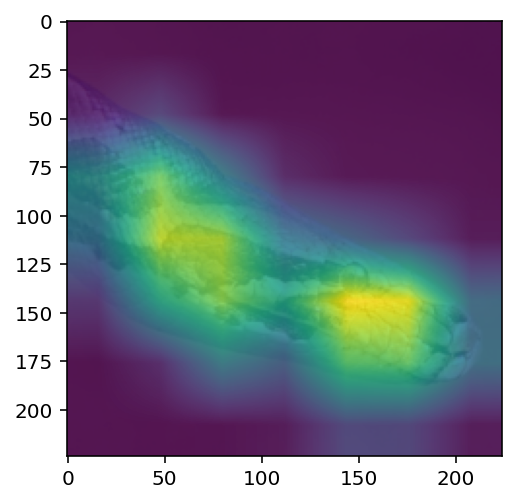

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature Dimensionality 128
Ground Truth: 	 rock python, rock snake, Python sebae
Predicted Label: 	 rock python, rock snake, Python sebae
Top 5 Predictions Labels:  	 ['rock python, rock snake, Python sebae', 'boa constrictor, Constrictor constrictor', 'night snake, Hypsiglena torquata', 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus', 'king snake, kingsnake']
Ground Truth Class ID 62 Predicted Class ID 62


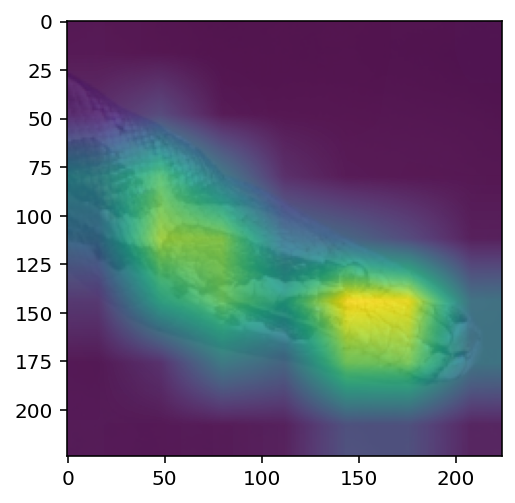

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature Dimensionality 256
Ground Truth: 	 rock python, rock snake, Python sebae
Predicted Label: 	 rock python, rock snake, Python sebae
Top 5 Predictions Labels:  	 ['rock python, rock snake, Python sebae', 'boa constrictor, Constrictor constrictor', 'night snake, Hypsiglena torquata', 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus', 'king snake, kingsnake']
Ground Truth Class ID 62 Predicted Class ID 62


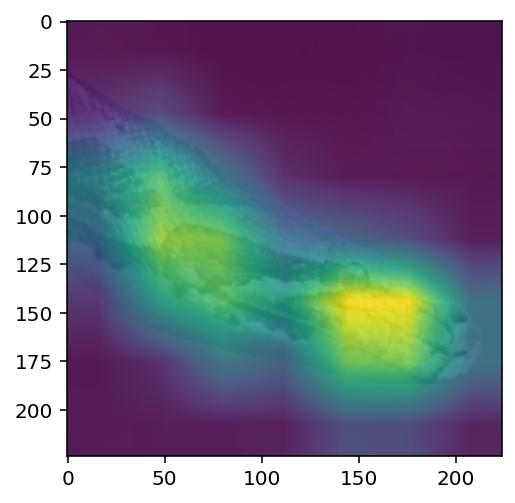

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature Dimensionality 512
Ground Truth: 	 rock python, rock snake, Python sebae
Predicted Label: 	 rock python, rock snake, Python sebae
Top 5 Predictions Labels:  	 ['rock python, rock snake, Python sebae', 'boa constrictor, Constrictor constrictor', 'night snake, Hypsiglena torquata', 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus', 'king snake, kingsnake']
Ground Truth Class ID 62 Predicted Class ID 62


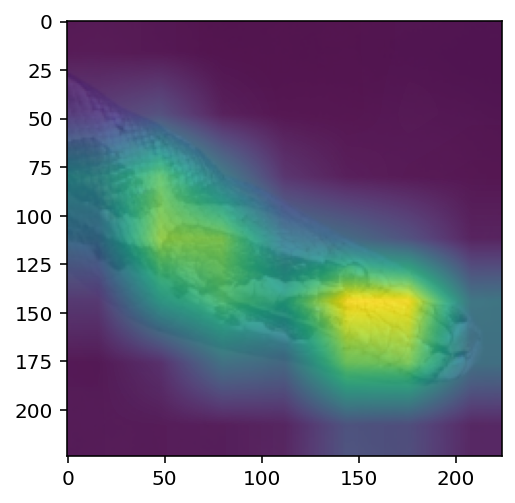

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature Dimensionality 1024
Ground Truth: 	 rock python, rock snake, Python sebae
Predicted Label: 	 rock python, rock snake, Python sebae
Top 5 Predictions Labels:  	 ['rock python, rock snake, Python sebae', 'boa constrictor, Constrictor constrictor', 'night snake, Hypsiglena torquata', 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus', 'king snake, kingsnake']
Ground Truth Class ID 62 Predicted Class ID 62


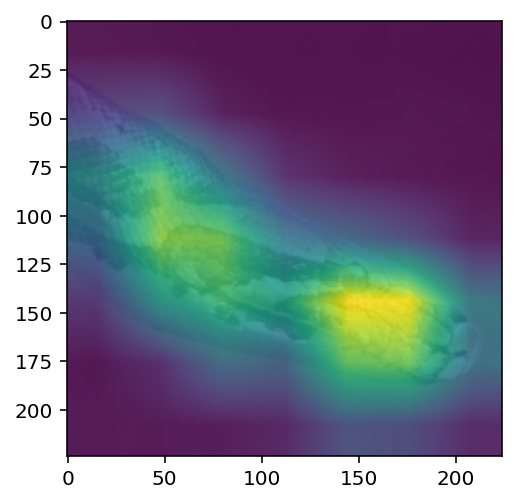

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature Dimensionality 2048
Ground Truth: 	 rock python, rock snake, Python sebae
Predicted Label: 	 rock python, rock snake, Python sebae
Top 5 Predictions Labels:  	 ['rock python, rock snake, Python sebae', 'boa constrictor, Constrictor constrictor', 'night snake, Hypsiglena torquata', 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus', 'king snake, kingsnake']
Ground Truth Class ID 62 Predicted Class ID 62


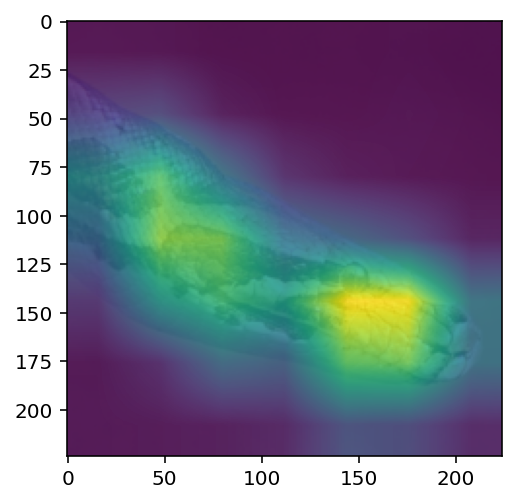

In [39]:
# Following example shows how Rep. Size=8 can get confused between the classes within the same superclass. 
k=0
plt.imshow(torch.permute(inv_normalize(X_)[k], (1, 2, 0)).cpu().numpy())
plt.show()
for i, feat_dim in enumerate([2**i for i in range(3, 12)]):
    print("Feature Dimensionality", feat_dim)
    print("Ground Truth: \t", id_name_mapping[class_specific_idx]['label'])
    print("Predicted Label: \t", id_name_mapping[preds_[i, k].item()]['label'])
    # printing top-5 predictions 
    print("Top 5 Predictions Labels:  \t", [id_name_mapping[(sofmtax_top5_[i, k, j].item())]['label'] for j in range(5)])
    print("Ground Truth Class ID",class_specific_idx, "Predicted Class ID",  preds_[i, k].item())
    
    plt.imshow(all_gradcam["sh"][feat_dim][k])
    plt.imshow(torch.permute(inv_normalize(X_)[k], (1, 2, 0)).cpu().numpy(), alpha=0.15)
    plt.show()

## For Figure 9 like plots... 

In [223]:
X_montage=[]
l=[torch.permute(inv_normalize(X_)[k], (1, 2, 0)).cpu().numpy()]
for feat_dim in [2**i for i in range(3, 12)]:
    foo = all_gradcam["sh"][feat_dim][k]
    plt.imsave("foo.png",foo)
    xx = cv2.cvtColor(imageio.imread("foo.png"), cv2.COLOR_BGRA2BGR)/255
    l.append(0.7*xx+0.3*torch.permute(inv_normalize(X_)[k], (1, 2, 0)).cpu().numpy())
    
X_montage.append(np.asarray(l))


In [224]:
M = np.concatenate(X_montage, axis=0)

In [ ]:
m = montage(M[[0,1,2,3, -1]],channel_axis=3,grid_shape=(1, 5), multichannel=True)
skimage.io.imsave('montage_1.jpg', m)
